1. Imports necessary libraries

In [1]:
from PIL import Image
import requests
import base64
import hashlib
from tqdm import tqdm
import pandas as pd
from elasticsearch import Elasticsearch
import io
from dataProcessor import process_metadata, clean_text, correct_misinterpreted_characters, pew_metadata_path, statista_metadata_path, llava_description_path

2. Loading and Processing Metadata
- The script processes metadata from multiple sources (pew_metadata_path, statista_metadata_path, llava_description_path) into a single DataFrame using the process_metadata function.

In [2]:
#  get the combined dataframe
combined_df = process_metadata(pew_metadata_path, statista_metadata_path, llava_description_path)
combined_df.shape

(29354, 5)

- Text fields (title, caption, and llava_description) are cleaned and corrected to ensure data quality before indexing.

In [3]:
# Apply text cleaning and correction functions
combined_df['title'] = combined_df['title'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['caption'] = combined_df['caption'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['llava_description'] = combined_df['llava_description'].apply(clean_text).apply(correct_misinterpreted_characters)

In [4]:
combined_df

,id,title,caption,imgPath,llava_description
0,1,"Foreign-born population in the United States, ...",The foreign-born population residing in the U....,../dataset/pew_dataset/pew_imgs/1.png,The chart you've provided appears to be a line...
1,2,"English proficiency among U.S. immigrants, 198...","Since 1980, the share of immigrants who are pr...",../dataset/pew_dataset/pew_imgs/2.png,The chart you've provided shows the percentage...
2,3,"Languages spoken among U.S. immigrants, 2018","Among the nation’s immigrants, Spanish is by f...",../dataset/pew_dataset/pew_imgs/3.png,The chart presents the percentage of immigrant...
3,4,"Hispanic population in the U.S., 2000-2017",There were nearly 60 million Latinos in the Un...,../dataset/pew_dataset/pew_imgs/4.png,The chart you've provided appears to be a line...
4,5,Weekly broadcast audience for top 20 NPR-affil...,The top 20 NPR-affiliated public radio station...,../dataset/pew_dataset/pew_imgs/5.png,The chart you've provided is a line graph show...
...,...,...,...,...,...
29349,29350,Distribution of cyber stalking victims in 2013...,This statistic presents the distribution of cy...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a bar ...
29350,29351,Total number of dwellings in Great Britain fro...,This statistic displays the total number of dw...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a line...
29351,29352,Results in the European Parliament elections i...,This statistic shows the political parties and...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a bar ...
29352,29353,Average annual expenditure on curtains and dra...,This statistic shows the average annual expend...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a line...


3. Connecting to Elasticsearch and Creating the Index
- The script initializes an Elasticsearch client pointing to a local instance at http://localhost:9200.
- It checks whether the "documents" index already exists.
- If the index does not exist, it creates a new one with predefined mappings, defining the given fields.

In [5]:
# Elasticsearch intialization
es = Elasticsearch(["http://localhost:9200"])
index_name = "documents"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},
                "llava_content": {"type": "text"}
            }
        }
    })
# The document already exist

4. Encoding Images in Base64
- A helper function image_to_base64(image_path) reads image files, converts them to Base64 encoding, and returns the encoded string.
- This allows storing images in Elasticsearch as text data.

In [6]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode image bytes to Base64
        base64_img = base64.b64encode(img_bytes).decode("utf-8")
        return base64_img

5. Indexing Documents into Elasticsearch
- The script loops through each row in combined_df, extracting title, caption, and llava_description.
- A unique document ID is generated using the SHA-256 hash of the title and caption to prevent duplicates.
- The image associated with the document is converted to Base64 and stored in the "image_data" field.
- The document is indexed into Elasticsearch with these fields:
     - "title": The cleaned title of the document.
     - "content": The cleaned caption.
     - "llava_content": Processed content from Llava metadata.
     - "image_data": Base64-encoded image data.

In [17]:
# Indexing the documents into embeddings using Elasticsearch with its unique ID, ensuring no duplicates are created.
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Concatenate title and caption with a space or some delimiter
    combined_text = f"{row['title']}. {row['caption']}"

    # Generate a unique ID for the document using a hash of the title and caption
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Get Base64-encoded image data
    image_path = row['imgPath']
    base64_image_data = image_to_base64(image_path)
    
    # Index the document with the combined embedding, image data, and use the unique_id as the document ID
    es.index(index=index_name, id=unique_id, body={
        "title": row['title'],
        "content": row['caption'],
        "llava_content": row['llava_description'],
        "image_data": base64_image_data,
    })


100%|██████████| 29354/29354 [03:15<00:00, 149.85it/s]


6. Searching for Relevant Documents using BM25
- The script performs a BM25 search query in Elasticsearch to find the most relevant documents for a given query.
- The query searches in the content and title fields using "multi_match" to retrieve the top 3 results.
- The "tie_breaker" parameter balances field relevance.

Top 3 relevant documents for the topic 'Does poverty cause crime?':

1. Title: Reported violent crime rate in the U.S. in 2019, by state
   Content: In 2019, the District of Columbia had the highest reported violent crime rate in the United States, with 1,049 violent crimes per 100,000 of the population. Maine had the lowest reported violent crime rate, with 115.2 offenses per 100,000 of the population. Life in the District The District of Columbia has seen a fluctuating population over the past few decades. Its population decreased throughout the 1990s, when its crime rate was at its peak, but has been steadily recovering since then. While unemployment in the District has also been falling, it still has an extremely high poverty rate. The gentrification of certain areas within Washington, D.C. over the past few years has made the contrast between rich and poor even greater and is also pushing crime out into the Maryland and Virginia suburbs around the District. Law enforcement in the 

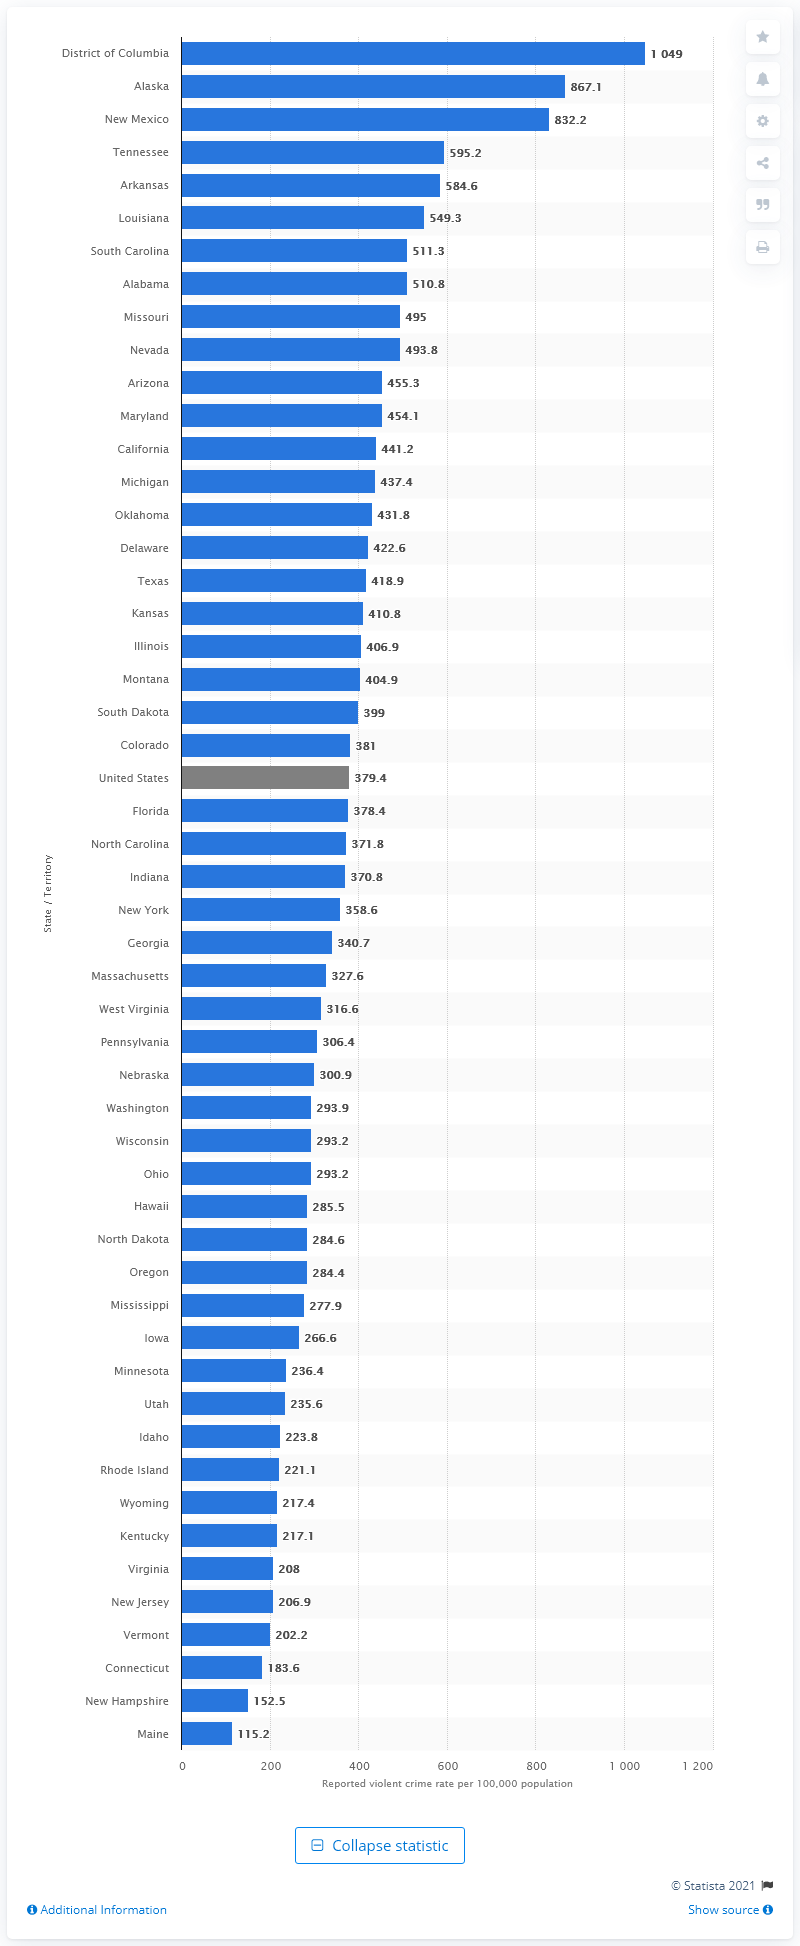

2. Title: Crime rate in the United States in 2019, by type of crime                                                     (per 100,000 inhabitants)
   Content: This statistic shows the crime rate in the United States in 2019, by type of crime. In 2019, the violent crime rate was at 383.4 cases per 100,000 inhabitants.
   Score: 11.979868



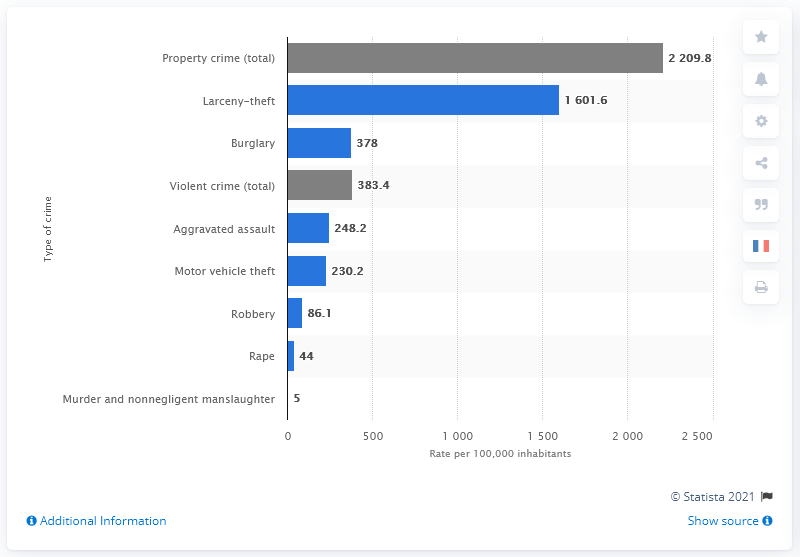

3. Title: Ukraine: Poverty headcount ratio from 2008 to 2018
   Content: This statistic shows the poverty headcount ratio at national poverty lines in Ukraine from 2008 to 2018. In 2018, the poverty headcount ratio at national poverty lines in Ukraine amounted to 1.3 percent.
   Score: 11.971384



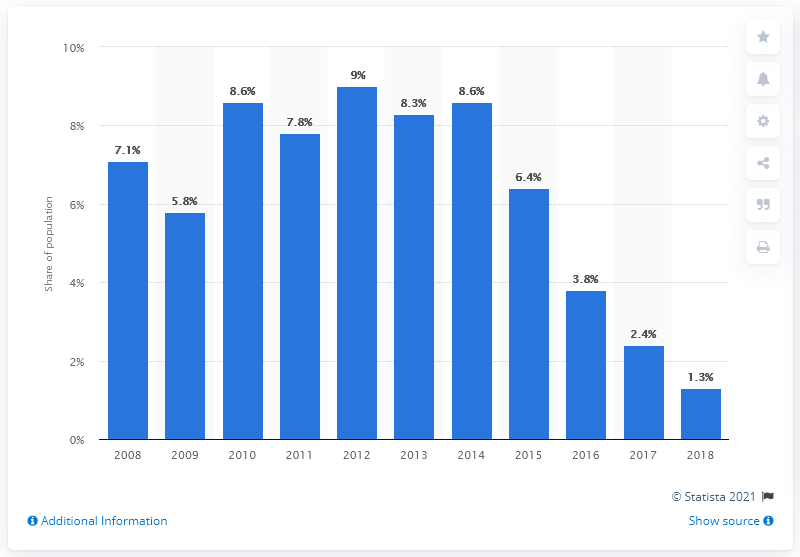

In [9]:
# Define the index name and the random topic
index_name = "documents"
random_topic = "Does poverty cause crime?" 
# Is China Seen as Leading Economic Power?

# Elasticsearch query to find relevant documents based on BM25 using content and title fields
bm25_query = {
    "query": {
        "multi_match": {
            "query": random_topic,
            "type": "best_fields",  # Optional: You can adjust the type as needed
            "fields": ["content", "title"],  # Search in both content and title fields
            "tie_breaker": 0.3  # Optional: You can adjust the tie breaker as needed
        }
    }
}

# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": bm25_query['query'],  # Use the corrected query structure
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{random_topic}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data if available
    if 'image_data' in doc:
        image_bytes = base64.b64decode(doc['image_data'])
        
        # Open the image from bytes
        image = Image.open(io.BytesIO(image_bytes))
        
        # Display the image
        image.show()

8. Running Another BM25 Query with Different Fields
- A second BM25 query is executed, searching in title and llava_content fields instead of content.
- The same top 3 results are printed along with any associated images.

Top 3 relevant documents for the topic 'Does poverty cause crime':

1. Title: Change in crime rate in Sweden in 2019, by type of crime
   Content: In 2019, around 1.5 million crimes were committed in Sweden. The number of crimes increased from 2013 onwards. The largest change in crime rate in 2019 was for property damage crimes, which increased by eight percent compared to the previous year. Distribution of crimes Property damage crime had the highest change in crime rate, but accounted only for 13 percent of all reported crimes in 2019, which was the fourth largest share. The most common crime was theft crime, which accounted for 28 percent of all crimes, but decreased by two percent compared to the previous year. Crimes against people was the second largest type of crime, which accounted for 19 percent of all crimes. Number of reported cyber crimes The largest and still increasing share of fraud crimes are cyber frauds. In 2018, around 260 thousand fraud crimes were reported, and lit

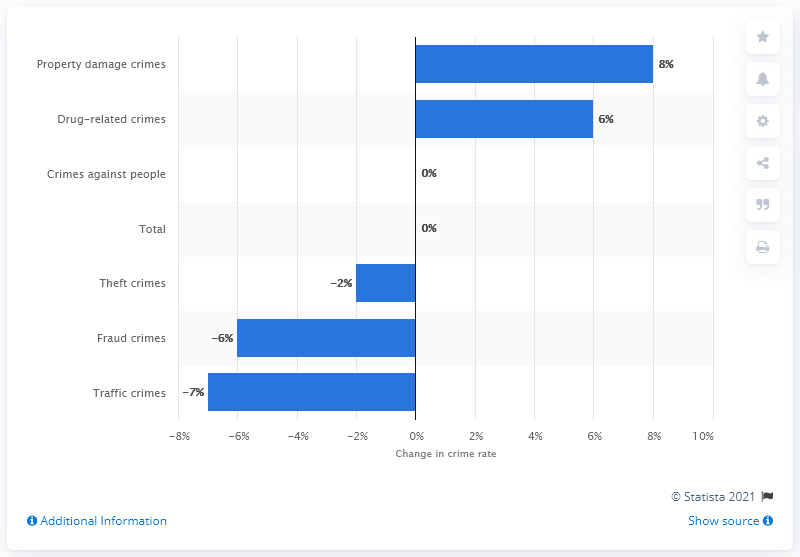

2. Title: Number of deaths in Sweden in 2019, by cause of death
   Content: In 2019, almost 89 thousand individuals died in Sweden. Even though the number of deaths was kept at a relatively stable number from 2010 to 2020, this was the lowest number of deaths during the whole period. The most common cause of death was diseases in the circulatory system, causing about 28 thousand deaths in 2019. Ischemic heart disease most common cause Chronic ischemic heart disease is among the circulation system diseases the one that causes the most deaths. When ischemic heart disease occurs, the arteries of the heart are blocked and the blood flow to the heart muscle is reduced. In 2018, 56.24 deaths occurred among hundred thousand inhabitants in Sweden due to the disease. The second and third most common causes of death The second largest cause of death in Sweden in 2018 was neoplasms (tumors), which caused around 23.5 thousand deaths. This was followed by diseases in the respiratory system, which c

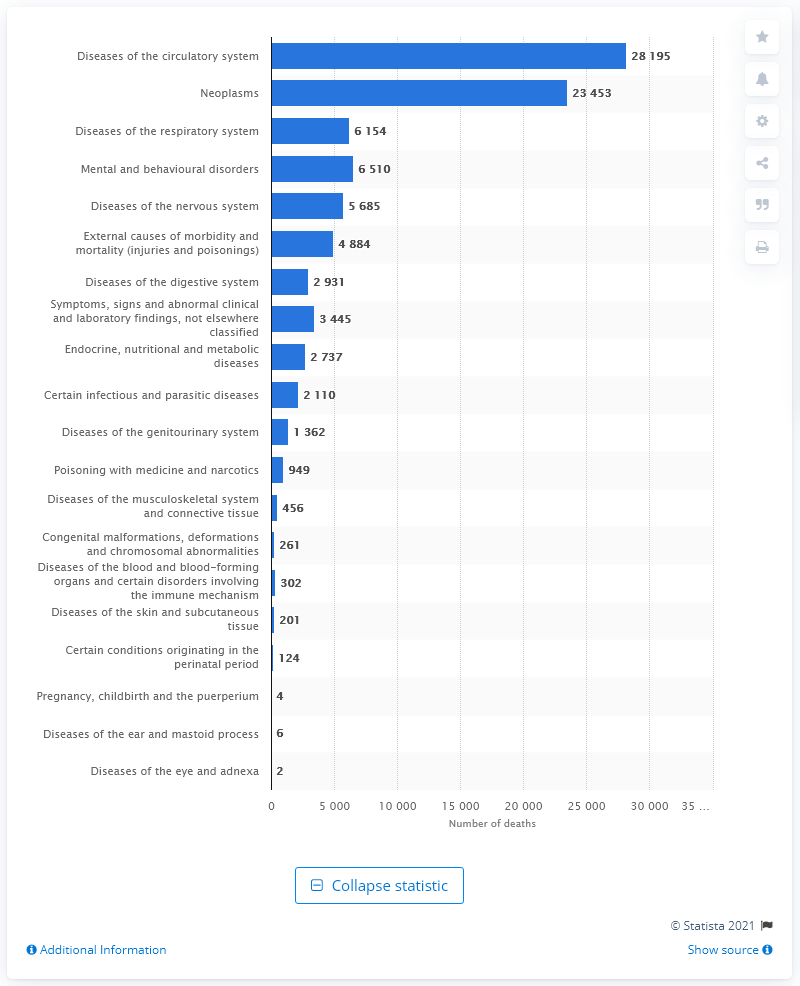

3. Title: Number of deaths in Belgium in 2016, by cause of death
   Content: This statistic displays the number of deaths in Belgium in 2016, by cause of death. In 2016, about approximately 29,000 people died of neoplasms.
   Score: 9.074501



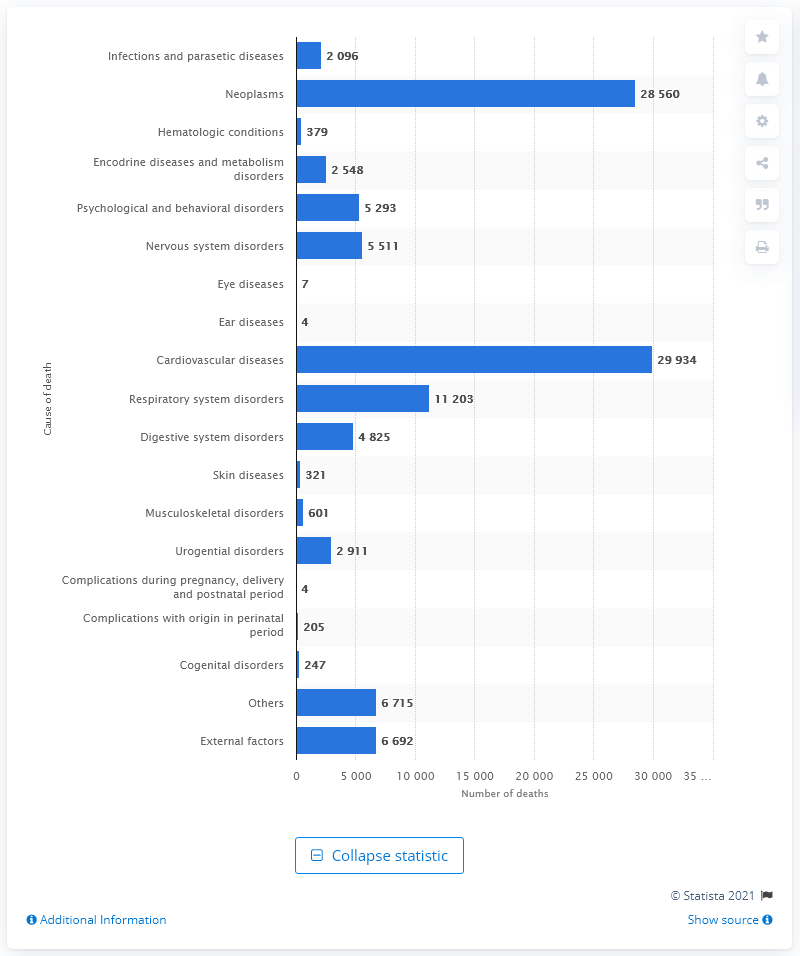

In [10]:
# Define the index name and the random topic
index_name = "documents"
random_topic = "Does poverty cause crime"

# Elasticsearch query to find relevant documents based on BM25 using content and title fields
bm25_query = {
    "query": {
        "multi_match": {
            "query": random_topic,
            "type": "best_fields",  # Optional: You can adjust the type as needed
            "fields": ["title", "llava_content"],  # Search in both content and title fields
            "tie_breaker": 0.3  # Optional: You can adjust the tie breaker as needed
        }
    }
}

# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": bm25_query['query'],  # Use the corrected query structure
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{random_topic}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data if available
    if 'image_data' in doc:
        image_bytes = base64.b64decode(doc['image_data'])
        
        # Open the image from bytes
        image = Image.open(io.BytesIO(image_bytes))
        
        # Display the image
        image.show()